In [1]:
import json

file_path = 'recomendations/output-bielik/scores.json'

# Read JSON data from the file
with open(file_path, 'r', encoding='utf-8') as file:
    data_bielik = json.load(file)

file_path = 'recomendations/output-gpt-4o-mini/scores.json'

# Read JSON data from the file
with open(file_path, 'r', encoding='utf-8') as file:
    data_mini = json.load(file)

file_path = 'recomendations/output-gpt-4.1-nano/scores.json'

# Read JSON data from the file
with open(file_path, 'r', encoding='utf-8') as file:
    data_nano = json.load(file)



In [2]:
rename_map = {
    'Tryb': 'Course Conduct Mode',
    'Kryteria': 'Passing Criteria',
    'Tematyka': 'Preferred Course Topics',
    'wszystkie': 'All Categories Combined'
}

def rename_top_keys(data_dict):
    return {rename_map.get(k, k): v for k, v in data_dict.items()}

data_bielik = rename_top_keys(data_bielik)
data_mini = rename_top_keys(data_mini)
data_nano = rename_top_keys(data_nano)

In [19]:
data_bielik['All Categories Combined'].keys()

dict_keys(['w1', 'w2', 'w3'])

In [4]:
def get_RES(data):
    RES = {}
    for key2, value2 in data.items():
        res1 = []
        res2 = []
        for key1, value1 in value2.items():
            for key, value in value1.items():
                r1, r2 = value
                res1.append(r1)
                res2.append(r2)
        RES[key2] = [res1, res2]
    return RES

In [5]:
import numpy as np

RES_models = {}
for model in ['bielik-1.5B-v3.0', "gpt-4-1-nano", "gpt-4o-mini"]:
    if model == 'bielik-1.5B-v3.0':
        data = data_bielik
    if model == 'gpt-4-1-nano':
        data = data_nano
    if model == 'gpt-4o-mini':
        data = data_mini

    RES = get_RES(data)
    RES_metrics = {}
    for key, value in RES.items():
        RES_metrics[key] = {}

        res1, res2 = value
        error = len([True for r1, r2 in zip(res1, res2) if r1 == -1 or r2 ==-1])/len(res1)
        v1_filtered = [r1 for r1, r2 in zip(res1, res2) if r1 != -1 and r2 !=-1]
        v2_filtered = [r2 for r1, r2 in zip(res1, res2) if r1 != -1 and r2 !=-1]

        mean1 = np.mean(v1_filtered)
        mean2 = np.mean(v2_filtered)


        if key == 'All Categories Combined':
            pairs = list(zip(res1, res2))
            triplets = [pairs[i:i+3] for i in range(0, len(pairs), 3)]

            scores_positives = []
            err = 0
            for triplet in triplets:
                if any(r1 == -1 or r2 == -1 for r1, r2 in triplet):
                    err += 1
                    continue
                positive = all(r1 > r2 for r1, r2 in triplet)
                scores_positives.append(positive)
            error = err / len(triplets)
        else:
            scores_positives = [r1 > r2 for r1, r2 in zip(res1, res2) if r1 != -1 and r2 !=-1]

        TP = scores_positives.count(True)
        FN = scores_positives.count(False)

        total = len(scores_positives)
        accuracy = TP / total

        RES_metrics[key]['len'] = len(res1)
        RES_metrics[key]['error'] = error
        RES_metrics[key]['valid'] = len(v1_filtered)/ len(res1)
        RES_metrics[key]['mean1'] = mean1
        RES_metrics[key]['mean2'] = mean2
        RES_metrics[key]['accuracy'] = accuracy
    RES_models[model] = RES_metrics

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Assume RES_models is already defined
models = list(RES_models.keys())
categories = list(next(iter(RES_models.values())).keys())

# Extract metric matrices: shape (n_categories, n_models)
def extract_metric(metric):
    return np.array([[RES_models[model][cat][metric] for model in models] for cat in categories])

errors = extract_metric('error')
valids = extract_metric('valid')
accuracies = extract_metric('accuracy')
mean1s = extract_metric('mean1')
mean2s = extract_metric('mean2')
lengths = extract_metric('len').astype(int)

# CI estimation
def ci_bounds(mean, n, std=1.0, conf=0.95):
    h = stats.t.ppf((1 + conf) / 2.0, n - 1) * std / np.sqrt(n)
    return h

mean1_ci = np.array([[ci_bounds(m, l) for m, l in zip(mean_row, len_row)]
                     for mean_row, len_row in zip(mean1s, lengths)])
mean2_ci = np.array([[ci_bounds(m, l) for m, l in zip(mean_row, len_row)]
                     for mean_row, len_row in zip(mean2s, lengths)])

# Plot config
x = np.arange(len(models))  # X-axis: models
total_width = 0.8
n_cats = len(categories)
bar_width = total_width / n_cats

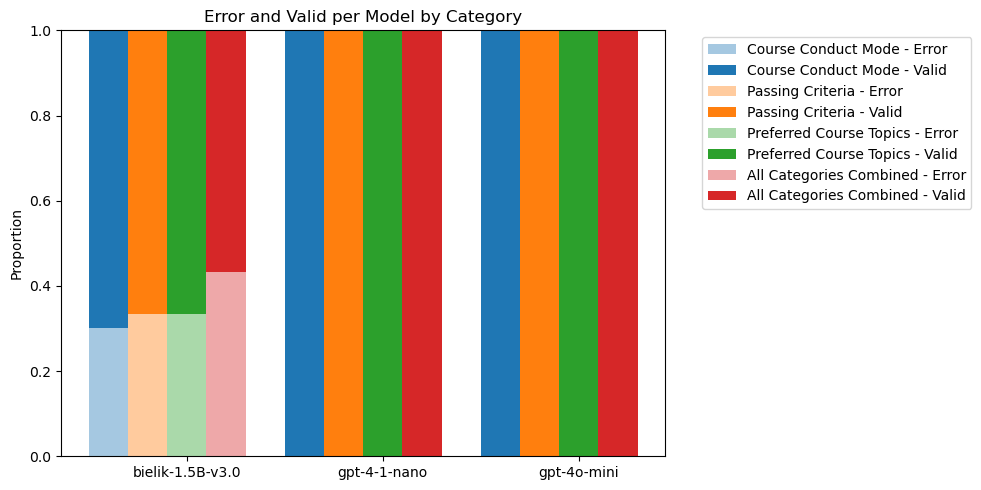

In [7]:
import matplotlib.colors as mcolors

# Base colors for each category
base_colors = plt.cm.tab10.colors
category_colors = {cat: base_colors[i % len(base_colors)] for i, cat in enumerate(categories)}

# ---------- PLOT 1: ERROR and VALID with category-specific colors ----------
fig, ax = plt.subplots(figsize=(10, 5))

for i, cat in enumerate(categories):
    base_color = category_colors[cat]
    error_color = mcolors.to_rgba(base_color, alpha=0.4)  # lighter for error
    valid_color = mcolors.to_rgba(base_color, alpha=1.0)  # darker for valid

    xpos = x - total_width / 2 + i * bar_width
    ax.bar(xpos, errors[i], bar_width, label=f'{cat} - Error', color=error_color)
    ax.bar(xpos, valids[i], bar_width, bottom=errors[i], label=f'{cat} - Valid', color=valid_color)

ax.set_title("Error and Valid per Model by Category")
ax.set_ylabel("Proportion")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)

# Custom legend
from matplotlib.patches import Patch
legend_elements = []
for cat in categories:
    base = category_colors[cat]
    legend_elements.append(Patch(facecolor=mcolors.to_rgba(base, 0.4), label=f"{cat} - Error"))
    legend_elements.append(Patch(facecolor=base, label=f"{cat} - Valid"))

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


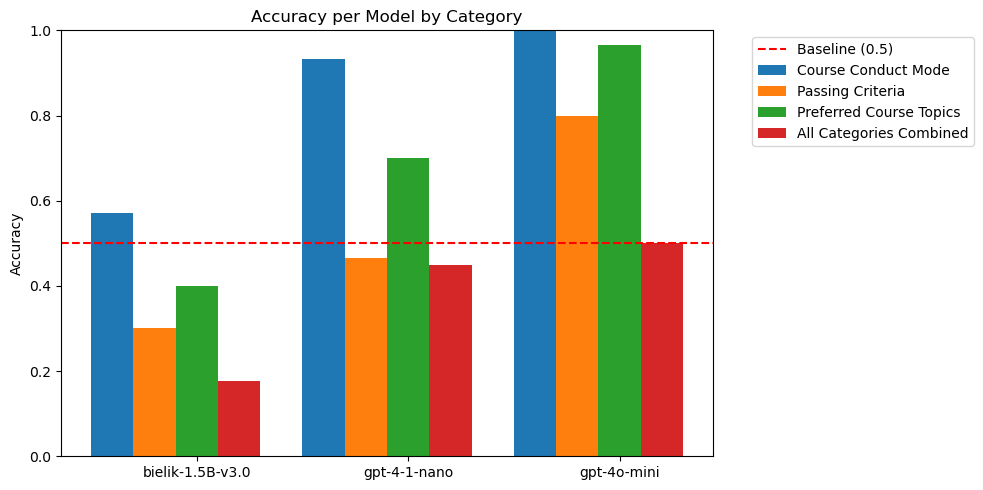

In [8]:

# ---------- PLOT 2: ACCURACY ----------
fig, ax = plt.subplots(figsize=(10, 5))
for i, cat in enumerate(categories):
    ax.bar(x - total_width/2 + i*bar_width, accuracies[i], bar_width, label=cat)

ax.axhline(0.5, linestyle='--', color='red', label='Baseline (0.5)')
ax.set_title("Accuracy per Model by Category")
ax.set_ylabel("Accuracy")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

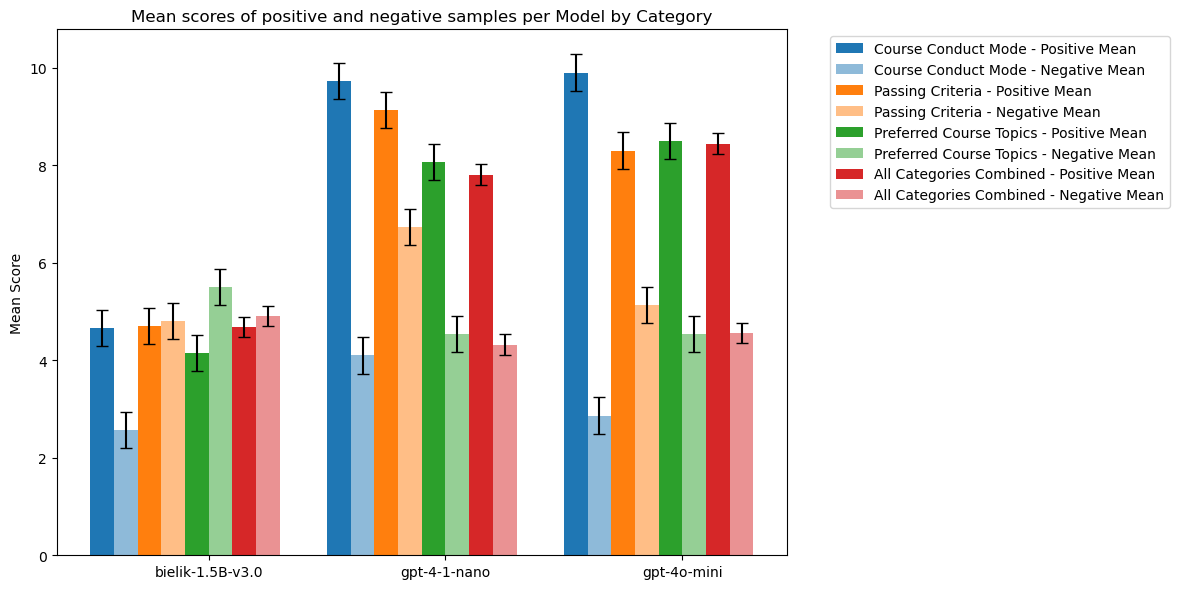

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define a unique base color per category
base_colors = plt.cm.tab10.colors  # You can replace this with another colormap
category_colors = {cat: base_colors[i % len(base_colors)] for i, cat in enumerate(categories)}

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
offset = bar_width / 2

for i, cat in enumerate(categories):
    base_color = category_colors[cat]
    mean2_color = mcolors.to_rgba(base_color, alpha=0.5)  # lighter (more transparent)
    mean1_color = mcolors.to_rgba(base_color, alpha=1.0)  # solid

    # Mean1
    ax.bar(
        x - total_width/2 + i*bar_width - offset/2,
        mean1s[i],
        bar_width/2,
        yerr=mean1_ci[i],
        label=f'{cat} - Mean1',
        capsize=4,
        color=mean1_color
    )

    # Mean2
    ax.bar(
        x - total_width/2 + i*bar_width + offset/2,
        mean2s[i],
        bar_width/2,
        yerr=mean2_ci[i],
        label=f'{cat} - Mean2',
        capsize=4,
        color=mean2_color
    )

ax.set_title("Mean scores of positive and negative samples per Model by Category")
ax.set_ylabel("Mean Score")
ax.set_xticks(x)
ax.set_xticklabels(models)

# Custom legend: one entry per category
from matplotlib.patches import Patch
legend_elements = []
for cat in categories:
    base = category_colors[cat]
    legend_elements.append(Patch(facecolor=base, label=f"{cat} - Positive Mean"))
    legend_elements.append(Patch(facecolor=mcolors.to_rgba(base, 0.5), label=f"{cat} - Negative Mean"))

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [10]:
def precision_recall_at_k(scores, true_labels, k):
    ranked_indices = np.argsort(scores)[::-1]  # descending sort
    top_k = ranked_indices[:k]
    pred_labels = np.zeros(len(scores), dtype=int)
    pred_labels[top_k] = 1
    TP = sum((pred_labels == 1) & (true_labels == 1))
    FP = sum((pred_labels == 1) & (true_labels == 0))
    FN = sum((pred_labels == 0) & (true_labels == 1))
    if key == 'All Categories Combined':
        print(model, 'K:', k)
        print(TP, FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return precision, recall

RES_models = {}
for model in ['bielik-1.5B-v3.0', "gpt-4-1-nano", "gpt-4o-mini"]:
    if model == 'bielik-1.5B-v3.0':
        data = data_bielik
    if model == 'gpt-4-1-nano':
        data = data_nano
    if model == 'gpt-4o-mini':
        data = data_mini

    RES = get_RES(data)
    RES_metrics = {}
    for key, value in RES.items():
        RES_metrics[key] = {}
        res1, res2 = value

        if key == 'All Categories Combined':
            pairs = list(zip(res1, res2))
            triplets = [pairs[i:i+3] for i in range(0, len(pairs), 3)]
            combined_labels = [1]*len(triplets) + [0]*len(triplets)
            scores_positives = []
            scores_negatives = []
            for triplet in triplets:
                if any(r1 == -1 or r2 == -1 for r1, r2 in triplet):
                    scores_positives.append(-1)
                    scores_negatives.append(-1)
                else:
                    positive = sum(r1 for r1, r2 in triplet)
                    negative = sum(r2 for r1, r2 in triplet)
                    scores_positives.append(positive)
                    scores_negatives.append(negative)
            combined_scores = scores_positives + scores_negatives
        else:
            # Combine scores and labels
            combined_scores = list(res1) + list(res2)
            combined_labels = [1]*len(res1) + [0]*len(res2)

        # Remove samples where score == -1 if those indicate invalid samples
        valid_indices = [i for i, score in enumerate(combined_scores) if score != -1]
        filtered_scores = np.array([combined_scores[i] for i in valid_indices])
        filtered_labels = np.array([combined_labels[i] for i in valid_indices])

        RES_metrics[key]['Precision@5'], RES_metrics[key]['Recall@5'] = precision_recall_at_k(filtered_scores, filtered_labels, 5)
        RES_metrics[key]['Precision@10'], RES_metrics[key]['Recall@10'] = precision_recall_at_k(filtered_scores, filtered_labels, 10)

    RES_models[model] = RES_metrics

bielik-1.5B-v3.0 K: 5
1 16
bielik-1.5B-v3.0 K: 10
4 13
gpt-4-1-nano K: 5
4 25
gpt-4-1-nano K: 10
9 20
gpt-4o-mini K: 5
5 25
gpt-4o-mini K: 10
10 20


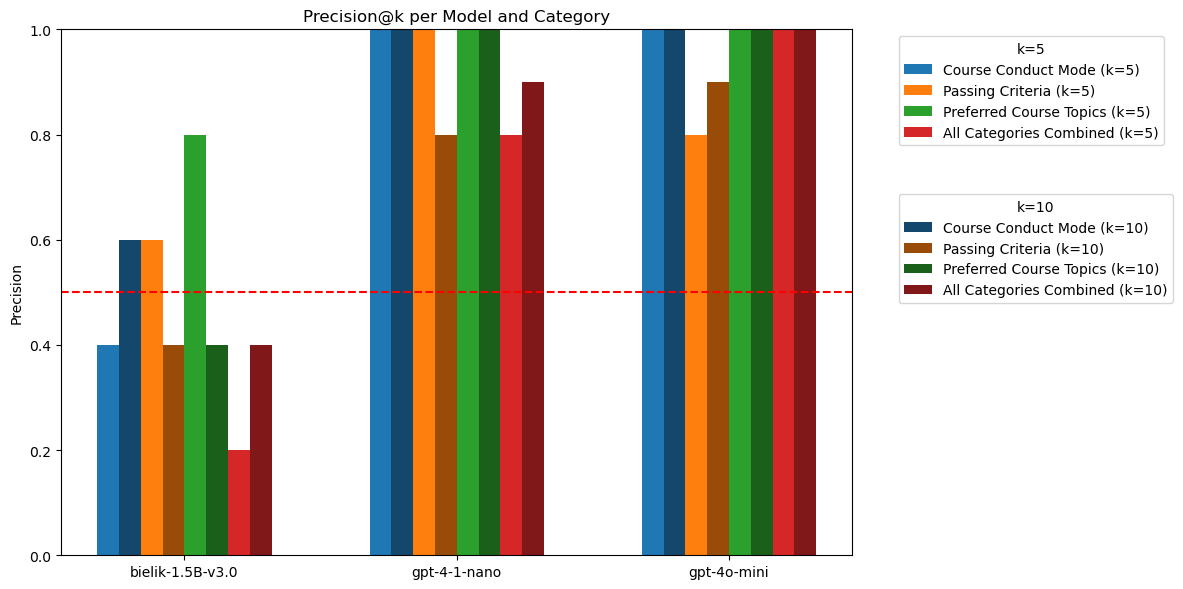

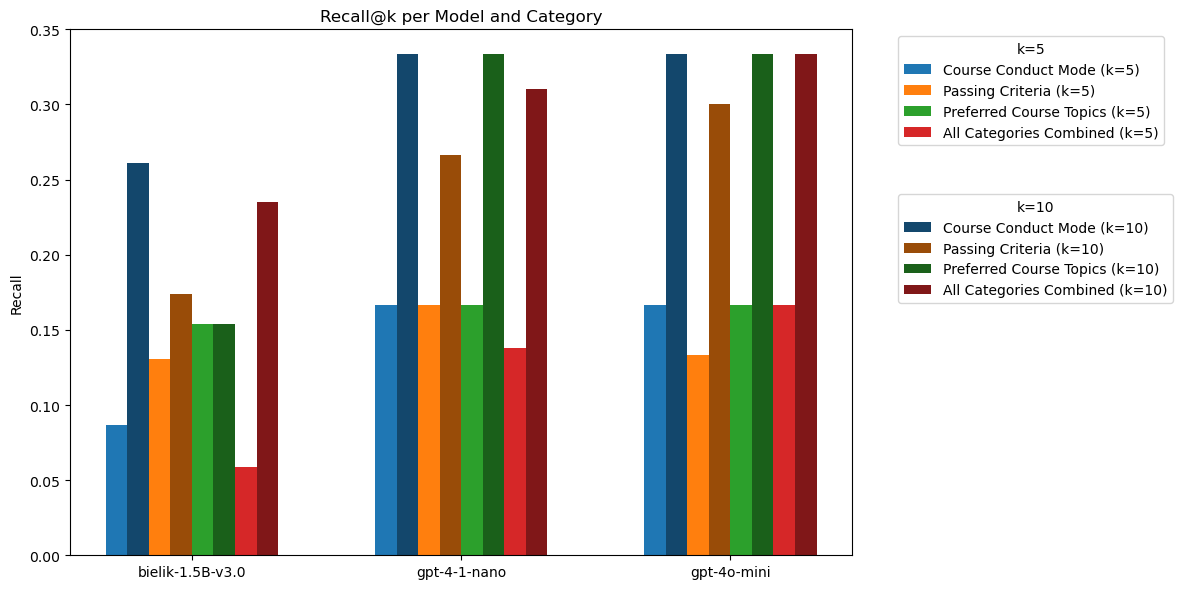

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

data = RES_models
models = list(data.keys())
categories = list(next(iter(data.values())).keys())
k_values = [5, 10]

bar_width = 0.08
n_metrics = len(k_values)
n_categories = len(categories)
total_width = n_metrics * n_categories * bar_width

x = np.arange(len(models))

# Choose distinct colors for categories
colors = plt.get_cmap('tab10').colors[:n_categories]

def plot_metric_grouped(metric_name):
    fig, ax = plt.subplots(figsize=(12, 6))

    legend_handles_5 = []
    legend_labels_5 = []
    legend_handles_10 = []
    legend_labels_10 = []

    for i_cat, cat in enumerate(categories):
        base_color = colors[i_cat]
        for i_k, k in enumerate(k_values):
            values = [data[model][cat][f'{metric_name}@{k}'] for model in models]

            # brightness factor: k=5 brighter, k=10 darker
            brightness = 1.0 if k == 5 else 0.6
            color = mcolors.to_rgba(base_color)
            color = (color[0]*brightness, color[1]*brightness, color[2]*brightness, color[3])

            offset = (i_cat * n_metrics + i_k) * bar_width - total_width / 2 + bar_width / 2

            bars = ax.bar(x + offset, values, bar_width, color=color)

            # Add legend handles/labels separately for k=5 and k=10
            if k == 5:
                legend_handles_5.append(bars)
                legend_labels_5.append(f'{cat} (k=5)')
            else:
                legend_handles_10.append(bars)
                legend_labels_10.append(f'{cat} (k=10)')

    if metric_name == 'Precision':
        ax.axhline(0.5, linestyle='--', color='red', label='Baseline (0.5)')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylabel(metric_name)
    if metric_name == 'Precision':
        ax.set_ylim(0, 1)
    ax.set_title(f'{metric_name}@k per Model and Category')

    # Combine legends for k=5 and k=10 with a little spacing
    first_legend = ax.legend(legend_handles_5, legend_labels_5, title='k=5',
                             bbox_to_anchor=(1.05, 1), loc='upper left')
    second_legend = ax.legend(legend_handles_10, legend_labels_10, title='k=10',
                              bbox_to_anchor=(1.05, 0.7), loc='upper left')

    ax.add_artist(first_legend)  # Add first legend back after second is created

    plt.tight_layout()
    plt.show()

plot_metric_grouped('Precision')
plot_metric_grouped('Recall')
